数据分析和清洗

In [30]:
import numpy as np
import torch
import pandas as pd
from transformers import AutoTokenizer
import pickle
import pandas as pd
pkl_name = 'data/EntityDataset_chat_usmle/ep_0.pkl'
input_ids_list, attention_mask_list, labels_list, hard_position_type_ids_list, position_ids_list, prompts_list = pickle.load(open(pkl_name, 'rb'))
input_len = pd.DataFrame([len(x) for x in input_ids_list])


max_len:  2048
cut_token_num:  0
cut_ratio:  0.0
cut ins num:  False    2
Name: count, dtype: int64
target_index:  0
seq_len:  830


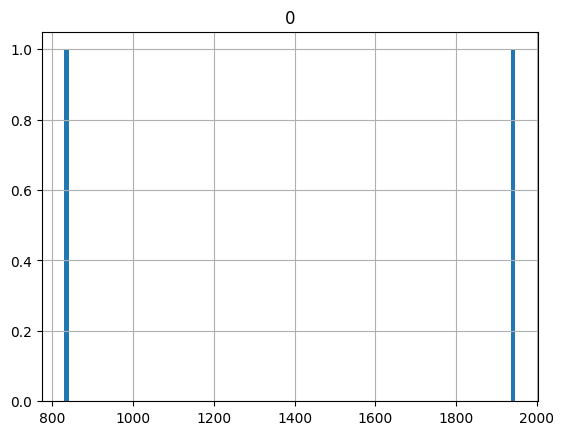

In [32]:
max_len = 2048
print('max_len: ', max_len)
cut_token_num = input_len.apply(lambda x: max(0,x[0]-max_len), axis=1)
cut_ratio = cut_token_num.sum() / input_len.sum()
print('cut_token_num: ', cut_token_num.sum())
print('cut_ratio: ', cut_ratio[0])
print('cut ins num: ', (cut_token_num>0).value_counts())
input_len.hist(bins=100)

tok = AutoTokenizer.from_pretrained('/home/cs/yangyuchen/yushengliao/Medical_LLM/FastChat/checkpoints/medical_llama_13b_chatv1.3/checkpoint-4974/')
tok.add_tokens(['[DASH]'])
target_index = [i for i,hpti in enumerate(hard_position_type_ids_list) if (hpti[1:]-hpti[:-1]==-1).sum()!=0][0]
print('target_index: ', target_index)
input_ids=input_ids_list[target_index]
attention_mask=attention_mask_list[target_index]
labels=labels_list[target_index]
hard_position_type_ids=hard_position_type_ids_list[target_index]
position_ids = position_ids_list[target_index]
prompt=prompts_list[target_index]
print('seq_len: ', input_ids.shape[-1])

tokens = tok.batch_decode(input_ids)
tokens = [t.replace('\n', '\\n') for t in tokens]
tokens = [f"{t}-{int(hard_position_type_ids[i])}-{position_ids[i]}-{int(int(labels[i])!=-100)}" for i,t in enumerate(tokens)]
attention_mask = attention_mask.numpy().tolist()
attention_mask = [[int(i) for i in row] for row in attention_mask]

matrix = attention_mask
row_index = tokens
col_index = tokens

max_row_length = max(len(row) for row in row_index)
max_col_length = max(len(col) for col in col_index)

# 打开文件
with open(f'{pkl_name}_{i}.txt', 'w') as f:
    f.write(prompt+ '\n\n')
    f.write('attention_mask:\n0:non-entity tokens，1:entity tokens, 2:triplet tokens, 3:triplet target tokens\n\n')
    # 写入列索引
    f.write(" " * max_row_length + "  " + "  ".join(col.ljust(max_col_length) for col in col_index) + '\n')
    # 写入行索引和每行的值
    for j, row in enumerate(matrix):
        f.write(row_index[j].ljust(max_row_length) + "  " + "  ".join(str(val).ljust(max_col_length) for val in row) + '\n')
        
# 创建DataFrame对象
df = pd.DataFrame(matrix, index=row_index, columns=col_index)

# 将DataFrame写入CSV文件
df.to_csv(f'{pkl_name}_{target_index}.csv')


In [27]:
import pandas as pd
import json
js = json.load(open('data/kg_chat_usmle_10178.json'))
df = pd.DataFrame(js)
df

,input,input_entities,output,output_entities,input_triplets,output_triplets
0,A 4-year-old boy presents to the opthalmologis...,[],The correct answer is B: Homocystinuria.\n\nHo...,"[homocysteine, cystathionine, methionine]",[],"[[103261], [100234, 120899], [105199]]"
1,A 56-year-old male with a history of hepatitis...,"[Paracentesis, ascitic fluid, lactulose, neomy...",Based on the clinical presentation and examina...,"[ammonia, urea, lactulose, hepatic, neomycin, ...","[[107943], [281458], [104302], [105811]]","[[97481], [110597], [104302], [116317], [10581..."
2,An 11-month-old boy is brought to the physicia...,"[Variable expressivity, Incomplete penetrance]",The correct answer is B: Pleiotropy.\n\nPleiot...,[],"[[187257], [186100]]",[]
3,A 17-year-old girl presents to the family doct...,"[class, somatic hypermutation]",D: V(D)J recombination results in the formatio...,[clone],"[[127234], [273721]]",[[166794]]
4,Five days after undergoing right knee arthropl...,[],This patient has signs and symptoms of an infe...,[],[],[]
...,...,...,...,...,...,...
10173,A 25-year-old man comes to the office because ...,[Phenylalanine],"This patient’s symptoms of arthropathy, ochron...","[homogentisic acid, tyrosine, phenylalanine, p...",[[107003]],"[[103262], [110521], [107003], [107198], [1097..."
10174,A 51-year-old man presents to the office with ...,"[Hypoalbuminemia, Hyperlipidemia]",The most likely cause of the generalized edema...,[Hyperlipidemia],"[[119535], [103489]]",[[103489]]
10175,A 61-year-old man presents to his primary care...,[Palpable purpura],This patient's clinical presentation is consis...,"[livedo reticularis, granulomatosis]",[[113840]],"[[113080], [129015]]"
10176,A 60-year-old man presents to the emergency de...,[demeclocycline],Based on the patient's presentation and labora...,"[Demeclocycline, hyponatremia]",[[100405]],"[[100405], [103544]]"


In [112]:
import numpy as np
import torch
import pandas as pd
from transformers import AutoTokenizer
import pickle
import pandas as pd
pkl_name = 'data/EntityDataset_chat_usmle/ep_0.pkl'
input_ids_list, attention_mask_list, labels_list, hard_position_type_ids_list, position_id, prompts_list = pickle.load(open(pkl_name, 'rb'))

In [113]:
total_kg_labels_num = sum([len((i==3).nonzero()) for i in hard_position_type_ids_list])
print('total_kg_labels_num: ', total_kg_labels_num)
total_labels_num = sum([len((i!=-100).nonzero()) for i in labels_list])
print('total_labels_num: ', total_labels_num)
kg_label_ratio = [len((hpti==3).nonzero()) / len((l!=-100).nonzero()) for hpti, l in zip(hard_position_type_ids_list, labels_list)]
print('mean kg_label_ratio: ', sum(kg_label_ratio)/len(kg_label_ratio))

total_kg_labels_num:  1936180
total_labels_num:  4438844
mean kg_label_ratio:  0.30885986573491697


In [110]:
import json
import pandas as pd


js = json.load(open("data/kg_chat_usmle_10178_old.json", "r"))
df = pd.DataFrame(js)
df['e_num'] = df.apply(lambda x: len(x['input_entities'] + x['output_entities']), axis=1)
df['t_num'] = df.apply(lambda x: len([j for i in x['input_triplets'] + x['output_triplets'] for j in i]), axis=1)
df['t_num'].sum()/df['e_num'].sum()
all_e = [j for i in df['input_entities'] + df['output_entities']for j in i]
pd.DataFrame(all_e).value_counts().hist(bins=100)

Inhibition         154
hyperthyroidism     89
DNA                 86
lithium             85
cirrhosis           84
                  ... 
atrophy             32
pancreatitis        32
mitral stenosis     32
pyrazinamide        32
dialysis            32
Name: count, Length: 100, dtype: int64

In [96]:
import json

answers = json.load(open("output/chat_usmle_baseline/panswer_usmle.json"))
correct = [a for a in answers if a['text'][0] == a['answer']]
print(f'correct: {len(correct)} acc: {len(correct)/len(answers)}')

correct: 451 acc: 0.35428122545168894


In [17]:
import jsonlines

js = list(jsonlines.open("data/medmcqa/train.json"))
import pandas as pd
df = pd.DataFrame(js)
df = df[df['exp'].notnull()]
df = df[df['choice_type'].isin(['single'])]
df

,question,exp,cop,opa,opb,opc,opd,subject_name,topic_name,id,choice_type
0,Chronic urethral obstruction due to benign pri...,Chronic urethral obstruction because of urinar...,3,Hyperplasia,Hyperophy,Atrophy,Dyplasia,Anatomy,Urinary tract,e9ad821a-c438-4965-9f77-760819dfa155,single
1,Which vitamin is supplied from only animal sou...,Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. ...,3,Vitamin C,Vitamin B7,Vitamin B12,Vitamin D,Biochemistry,Vitamins and Minerals,e3d3c4e1-4fb2-45e7-9f88-247cc8f373b3,single
4,Growth hormone has its effect on growth through?,"Ans. is 'b' i.e., IGI-1GH has two major functi...",2,Directly,IG1-1,Thyroxine,Intranuclear receptors,Physiology,None,dc6794a3-b108-47c5-8b1b-3b4931577249,single
5,Scrub typhus is transmitted by: September 2004,Ans. C i.e. Mite,3,Louse,Tick,Mite,Milk,Social & Preventive Medicine,None,5ab84ea8-12d1-47d4-ab22-668ebf01e64c,single
7,Per rectum examination is not a useful test fo...,PILONIDAL SINUS/DISEASE (Jeep Bottom; Driver's...,3,Anal fissure,Hemorrhoid,Pilonidal sinus,Rectal ulcer,Surgery,Urology,f3bf8583-231b-4b7a-828c-179b0f9ccdd9,single
...,...,...,...,...,...,...,...,...,...,...,...
182810,Cholesteatoma is seen in:,"(b) CSOM(Ref. Cummings, 6th ed., 2141)Choleste...",2,ASOM,CSOM,Secretory Otitis media,Otosclerosis,ENT,Disorders of Middle Ear (Otitis Media),934a6ba8-1573-4605-8a5e-fce2721155ca,single
182813,Enzyme replacement therapy is used for-,"Ans. is 'a' i.e., Gaucher's disease * Alglucer...",1,Gaucher's disease,Krabbe's disease,Metachromatic leukodystrophy,Tay Sach's disease,Biochemistry,Enzymes,5d4f09e3-65b1-4e92-84ad-b06ad40cd7cc,single
182815,Organism that causes emphysematous cholecystit...,Ref: Harrison's 18th editionExplanation:Emphys...,3,Salmonella typhi,Cytomegalovirus,Clostridium perfringens,Bacteroides,Medicine,Gall Bladder,ca769633-3650-4209-8d22-b81a2e171d25,single
182817,Most common site for extra mammary Paget&;s di...,.It is superficial manifestation of an intradu...,1,Vulva,Vagina,Penis,Anus,Surgery,Urology,04519631-61e3-4ef4-b2d6-c352cf349ded,single


In [18]:
from tqdm import tqdm
from transformers import AutoTokenizer
tqdm.pandas()

tok = AutoTokenizer.from_pretrained("/home/cs/yangyuchen/yushengliao/Medical_LLM/vicuna-7b")
df['input'] = df.progress_apply(lambda x : f"{x['question']} Options: {', '.join(['A: ' + x['opa'],'B: ' + x['opb'],'C: ' + x['opc'],'D: ' + x['opd']])}", axis=1)
df['output'] = df.progress_apply(lambda x : f"{['A','B','C','D'][x['cop']-1]} is the right answer. Explanation: {x['exp']}", axis=1)
df['input_len'] = df.progress_apply(lambda x : len(tok(x['input'])['input_ids']), axis=1)
df['output_len'] = df.progress_apply(lambda x : len(tok(x['output'])['input_ids']), axis=1)
df

 73%|███████▎  | 77846/106370 [00:00<00:00, 89657.00it/s]

100%|██████████| 106370/106370 [00:36<00:00, 2908.17it/s]


,question,exp,cop,opa,opb,opc,opd,subject_name,topic_name,id,choice_type,input,output,input_len,output_len
0,Chronic urethral obstruction due to benign pri...,Chronic urethral obstruction because of urinar...,3,Hyperplasia,Hyperophy,Atrophy,Dyplasia,Anatomy,Urinary tract,e9ad821a-c438-4965-9f77-760819dfa155,single,Chronic urethral obstruction due to benign pri...,C is the right answer. Explanation: Chronic ur...,57,122
1,Which vitamin is supplied from only animal sou...,Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. ...,3,Vitamin C,Vitamin B7,Vitamin B12,Vitamin D,Biochemistry,Vitamins and Minerals,e3d3c4e1-4fb2-45e7-9f88-247cc8f373b3,single,Which vitamin is supplied from only animal sou...,C is the right answer. Explanation: Ans. (c) V...,39,157
4,Growth hormone has its effect on growth through?,"Ans. is 'b' i.e., IGI-1GH has two major functi...",2,Directly,IG1-1,Thyroxine,Intranuclear receptors,Physiology,None,dc6794a3-b108-47c5-8b1b-3b4931577249,single,Growth hormone has its effect on growth throug...,B is the right answer. Explanation: Ans. is 'b...,47,161
5,Scrub typhus is transmitted by: September 2004,Ans. C i.e. Mite,3,Louse,Tick,Mite,Milk,Social & Preventive Medicine,None,5ab84ea8-12d1-47d4-ab22-668ebf01e64c,single,Scrub typhus is transmitted by: September 2004...,C is the right answer. Explanation: Ans. C i.e...,39,20
7,Per rectum examination is not a useful test fo...,PILONIDAL SINUS/DISEASE (Jeep Bottom; Driver's...,3,Anal fissure,Hemorrhoid,Pilonidal sinus,Rectal ulcer,Surgery,Urology,f3bf8583-231b-4b7a-828c-179b0f9ccdd9,single,Per rectum examination is not a useful test fo...,C is the right answer. Explanation: PILONIDAL ...,45,291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182810,Cholesteatoma is seen in:,"(b) CSOM(Ref. Cummings, 6th ed., 2141)Choleste...",2,ASOM,CSOM,Secretory Otitis media,Otosclerosis,ENT,Disorders of Middle Ear (Otitis Media),934a6ba8-1573-4605-8a5e-fce2721155ca,single,"Cholesteatoma is seen in: Options: A: ASOM, B:...",B is the right answer. Explanation: (b) CSOM(R...,38,63
182813,Enzyme replacement therapy is used for-,"Ans. is 'a' i.e., Gaucher's disease * Alglucer...",1,Gaucher's disease,Krabbe's disease,Metachromatic leukodystrophy,Tay Sach's disease,Biochemistry,Enzymes,5d4f09e3-65b1-4e92-84ad-b06ad40cd7cc,single,Enzyme replacement therapy is used for- Option...,A is the right answer. Explanation: Ans. is 'a...,52,99
182815,Organism that causes emphysematous cholecystit...,Ref: Harrison's 18th editionExplanation:Emphys...,3,Salmonella typhi,Cytomegalovirus,Clostridium perfringens,Bacteroides,Medicine,Gall Bladder,ca769633-3650-4209-8d22-b81a2e171d25,single,Organism that causes emphysematous cholecystit...,C is the right answer. Explanation: Ref: Harri...,53,264
182817,Most common site for extra mammary Paget&;s di...,.It is superficial manifestation of an intradu...,1,Vulva,Vagina,Penis,Anus,Surgery,Urology,04519631-61e3-4ef4-b2d6-c352cf349ded,single,Most common site for extra mammary Paget&;s di...,A is the right answer. Explanation: .It is sup...,39,153


100%|██████████| 106370/106370 [00:00<00:00, 147561.62it/s]


,question,exp,cop,opa,opb,opc,opd,subject_name,topic_name,id,choice_type,input,output,input_len,output_len,tokens_num
0,Chronic urethral obstruction due to benign pri...,Chronic urethral obstruction because of urinar...,3,Hyperplasia,Hyperophy,Atrophy,Dyplasia,Anatomy,Urinary tract,e9ad821a-c438-4965-9f77-760819dfa155,single,Chronic urethral obstruction due to benign pri...,C is the right answer. Explanation: Chronic ur...,57,122,179
1,Which vitamin is supplied from only animal sou...,Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. ...,3,Vitamin C,Vitamin B7,Vitamin B12,Vitamin D,Biochemistry,Vitamins and Minerals,e3d3c4e1-4fb2-45e7-9f88-247cc8f373b3,single,Which vitamin is supplied from only animal sou...,C is the right answer. Explanation: Ans. (c) V...,39,157,196
4,Growth hormone has its effect on growth through?,"Ans. is 'b' i.e., IGI-1GH has two major functi...",2,Directly,IG1-1,Thyroxine,Intranuclear receptors,Physiology,None,dc6794a3-b108-47c5-8b1b-3b4931577249,single,Growth hormone has its effect on growth throug...,B is the right answer. Explanation: Ans. is 'b...,47,161,208
5,Scrub typhus is transmitted by: September 2004,Ans. C i.e. Mite,3,Louse,Tick,Mite,Milk,Social & Preventive Medicine,None,5ab84ea8-12d1-47d4-ab22-668ebf01e64c,single,Scrub typhus is transmitted by: September 2004...,C is the right answer. Explanation: Ans. C i.e...,39,20,59
7,Per rectum examination is not a useful test fo...,PILONIDAL SINUS/DISEASE (Jeep Bottom; Driver's...,3,Anal fissure,Hemorrhoid,Pilonidal sinus,Rectal ulcer,Surgery,Urology,f3bf8583-231b-4b7a-828c-179b0f9ccdd9,single,Per rectum examination is not a useful test fo...,C is the right answer. Explanation: PILONIDAL ...,45,291,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182810,Cholesteatoma is seen in:,"(b) CSOM(Ref. Cummings, 6th ed., 2141)Choleste...",2,ASOM,CSOM,Secretory Otitis media,Otosclerosis,ENT,Disorders of Middle Ear (Otitis Media),934a6ba8-1573-4605-8a5e-fce2721155ca,single,"Cholesteatoma is seen in: Options: A: ASOM, B:...",B is the right answer. Explanation: (b) CSOM(R...,38,63,101
182813,Enzyme replacement therapy is used for-,"Ans. is 'a' i.e., Gaucher's disease * Alglucer...",1,Gaucher's disease,Krabbe's disease,Metachromatic leukodystrophy,Tay Sach's disease,Biochemistry,Enzymes,5d4f09e3-65b1-4e92-84ad-b06ad40cd7cc,single,Enzyme replacement therapy is used for- Option...,A is the right answer. Explanation: Ans. is 'a...,52,99,151
182815,Organism that causes emphysematous cholecystit...,Ref: Harrison's 18th editionExplanation:Emphys...,3,Salmonella typhi,Cytomegalovirus,Clostridium perfringens,Bacteroides,Medicine,Gall Bladder,ca769633-3650-4209-8d22-b81a2e171d25,single,Organism that causes emphysematous cholecystit...,C is the right answer. Explanation: Ref: Harri...,53,264,317
182817,Most common site for extra mammary Paget&;s di...,.It is superficial manifestation of an intradu...,1,Vulva,Vagina,Penis,Anus,Surgery,Urology,04519631-61e3-4ef4-b2d6-c352cf349ded,single,Most common site for extra mammary Paget&;s di...,A is the right answer. Explanation: .It is sup...,39,153,192


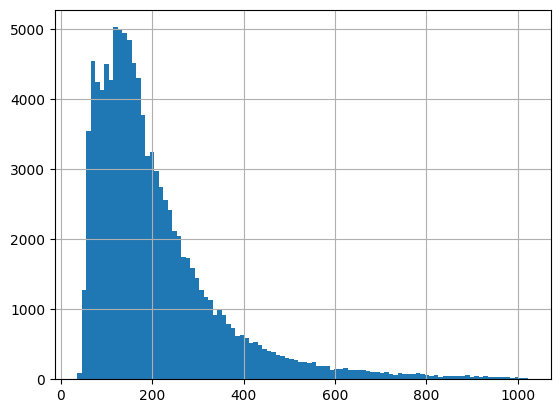

In [19]:
df['tokens_num'] = df.progress_apply(lambda x : x['input_len']+x['output_len'], axis=1)
df = df[df['tokens_num']<1024]
df['tokens_num'].hist(bins=100)
df

In [19]:
import bisect

a = [(0, 230), (272, 278), (313, 408), (487, 495), (551, 585), (599, 623), (637, 651), (717, 736), (802, 805), (860, 880), (959, 1003), (1069, 1088), (1154, 1169), (1183, 1211), (1277, 1301), (1315, 1386), (1421, 1470), (1484, 1518), (1532, 1563), (1642, 1653), (1709, 1730), (1744, 1765), (1871, 1877), (1933, 1946)]
bisect.bisect_right(a, 230, key=lambda x: x[1])

TypeError: 'key' is an invalid keyword argument for bisect_right()